<a href="https://colab.research.google.com/github/emircanbacanak/crypto_recommendation/blob/main/crypto_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
pip install tulipy


# Gerekli kütüphanlerin importu

In [128]:
import pandas as pd
import numpy as np
import tulipy as ti
import yfinance as yf
from datetime import datetime, timedelta

# Veriyi indir

In [165]:
end = datetime.now().strftime('%Y-%m-%d')
start = datetime.now() - pd.DateOffset(days=30)
data = yf.download("BTC-USD", start=start, end=end, interval="60m")
rsi_period = 14
close_prices = data['Close'].values

# RSI değerlerini hesapla
rsi_values = ti.rsi(close_prices, period=rsi_period)

buy_signal = rsi_values < 39
sell_signal = rsi_values > 70

# Al ve sat sinyallerinin olduğu zamanlardaki indeksleri bul
buy_indices = np.where(buy_signal)[0]
sell_indices = np.where(sell_signal)[0]

[*********************100%%**********************]  1 of 1 completed


# Al/Sat sinyallerinin doğruluk oranını hesaplar.

# Txt ye kaydet

In [166]:
# Al ve sat sinyallerini birleştir ve sırala
signals = np.sort(np.concatenate((buy_indices, sell_indices)))

correct_signals = []

for i in range(len(signals) - 1):
    # Eğer mevcut sinyal bir alım sinyaliyse
    if signals[i] in buy_indices:
        # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
        if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
            correct_signals.append(('Alım', signals[i], 'Satış', signals[i+1]))
    # Eğer mevcut sinyal bir satım sinyaliyse
    elif signals[i] in sell_indices:
        # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
        if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
            correct_signals.append(('Satış', signals[i], 'Alım', signals[i+1]))

# Doğru sinyalleri bir txt dosyasına yaz
output_file = "correct_signals.txt"

with open(output_file, 'w') as f:
    for i, signal in enumerate(correct_signals, 1):
        f.write(f"{i}- {signal[0]} {data.index[signal[1]]}, Fiyat: {data['Close'].values[signal[1]]}\n")
        f.write(f" {signal[2]} {data.index[signal[3]]}, Fiyat: {data['Close'].values[signal[3]]}\n")


# Rsı da al-sat gösterme


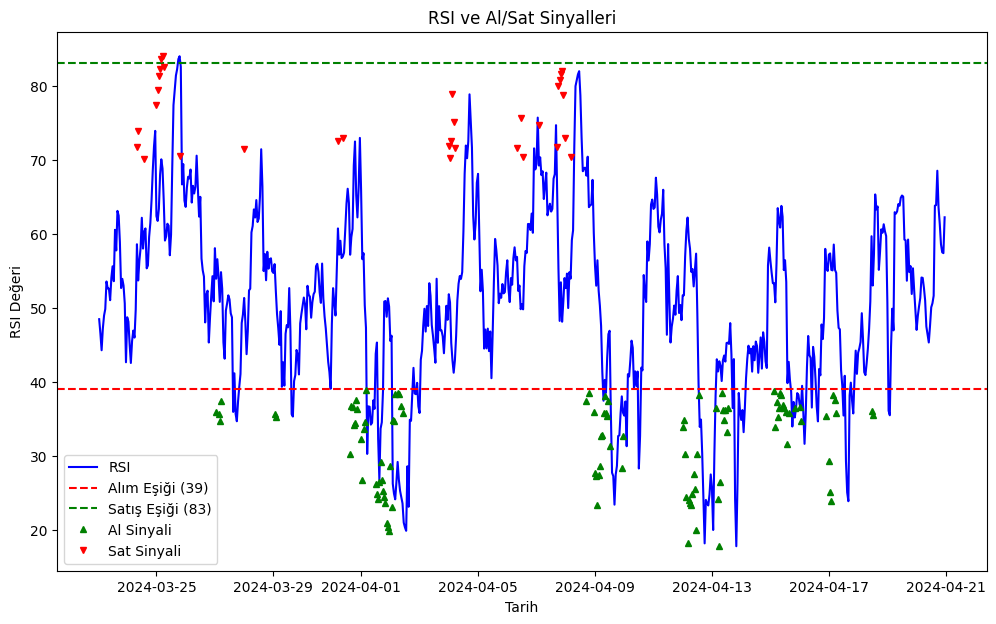

In [167]:
import matplotlib.pyplot as plt

rsi_length = len(rsi_values)

data_length = len(data)

plt.figure(figsize=(12, 7))
plt.plot(data.index[-rsi_length:], rsi_values, label='RSI', color='blue')
plt.axhline(y=39, color='r', linestyle='--', label='Alım Eşiği (39)')
plt.axhline(y=83, color='g', linestyle='--', label='Satış Eşiği (83)')

plt.plot(data.index[buy_indices[-rsi_length:]], rsi_values[buy_indices[-rsi_length:]], '^', markersize=5, color='green', label='Al Sinyali')

plt.plot(data.index[sell_indices[-rsi_length:]], rsi_values[sell_indices[-rsi_length:]], 'v', markersize=5, color='red', label='Sat Sinyali')

plt.title('RSI ve Al/Sat Sinyalleri')
plt.xlabel('Tarih')
plt.ylabel('RSI Değeri')
plt.legend()
plt.show()

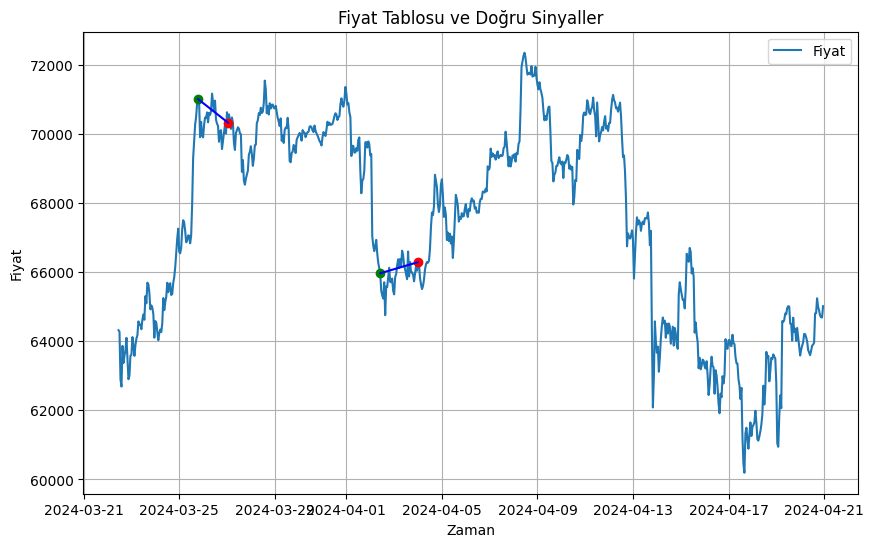

In [168]:
def plot_correct_signals(data, signals, buy_indices, sell_indices):
    # Al ve sat sinyallerini birleştir ve sırala
    signals = np.sort(np.concatenate((buy_indices, sell_indices)))

    correct_signals = []

    for i in range(len(signals) - 1):
        # Eğer mevcut sinyal bir alım sinyaliyse
        if signals[i] in buy_indices:
            # Sonraki sinyal bir satım sinyaliyse ve fiyat yükselmişse
            if signals[i+1] in sell_indices and data['Close'].values[signals[i+1]] > data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))
        # Eğer mevcut sinyal bir satım sinyaliyse
        elif signals[i] in sell_indices:
            # Sonraki sinyal bir alım sinyaliyse ve fiyat düşmüşse
            if signals[i+1] in buy_indices and data['Close'].values[signals[i+1]] < data['Close'].values[signals[i]]:
                correct_signals.append((signals[i], signals[i+1]))

    # Fiyat tablosunu çiz
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Fiyat')

    # Doğru sinyalleri işaretle
    for entry, exit in correct_signals:
        plt.plot(data.index[entry], data['Close'].values[entry], 'go')  # Al sinyali
        plt.plot(data.index[exit], data['Close'].values[exit], 'ro')   # Sat sinyali
        plt.plot([data.index[entry], data.index[exit]], [data['Close'].values[entry], data['Close'].values[exit]], 'b-')  # Bağlantı çizgisi

    plt.title('Fiyat Tablosu ve Doğru Sinyaller')
    plt.xlabel('Zaman')
    plt.ylabel('Fiyat')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonksiyonu kullanarak doğru sinyalleri görselleştir
plot_correct_signals(data, signals, buy_indices, sell_indices)
